<a href="https://colab.research.google.com/github/appliedcode/mthree-c422/blob/main/Exercises/day-4/Embedded_methods/Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Lab Exercises: Embedded Feature‐Selection Methods
# Use the Breast Cancer dataset (sklearn.datasets.load_breast_cancer) for all exercises. Split once into training and test sets:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X.columns.tolist()

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension',
 'radius error',
 'texture error',
 'perimeter error',
 'area error',
 'smoothness error',
 'compactness error',
 'concavity error',
 'concave points error',
 'symmetry error',
 'fractal dimension error',
 'worst radius',
 'worst texture',
 'worst perimeter',
 'worst area',
 'worst smoothness',
 'worst compactness',
 'worst concavity',
 'worst concave points',
 'worst symmetry',
 'worst fractal dimension']

# Exercise 1: L1-Regularized Logistic Regression
- Fit LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=5000).

- Use SelectFromModel (prefit) to select the 5 features with nonzero coefficients.

- Retrain a vanilla logistic model on those features.

- Report selected features and test accuracy.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

model_l1 = LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=5000)
model_l1.fit(X_train, y_train)

sfm_l1 = SelectFromModel(model_l1, prefit=True, max_features=5)
feat_l1 = X_train.columns[sfm_l1.get_support()]

model = LogisticRegression(max_iter=5000).fit(X_train[feat_l1], y_train)
print("L1 features:", list(feat_l1))
print("Accuracy (L1):", accuracy_score(y_test, model.predict(X_test[feat_l1])))


L1 features: ['mean perimeter', 'area error', 'worst radius', 'worst perimeter', 'worst area']
Accuracy (L1): 0.9590643274853801


# Exercise 2: L2-Regularization with Thresholding
- Fit LogisticRegression(penalty='l2', C=1.0, max_iter=5000).

- Extract absolute coefficients, select the 5 largest.

- Retrain and evaluate on those features.

In [23]:
import numpy as np

model_l2 = LogisticRegression(penalty='l2', C=1.0, max_iter=5000)
model_l2.fit(X_train, y_train)

abs_coefs = np.abs(model_l2.coef_)[0]
idx = np.argsort(abs_coefs)[-5:]
feat_l2 = X_train.columns[idx]

model = LogisticRegression(max_iter=5000).fit(X_train[feat_l2], y_train)
print("L2 features:", list(feat_l2))
print("Accuracy (L2):", accuracy_score(y_test, model.predict(X_test[feat_l2])))


L2 features: ['worst symmetry', 'worst compactness', 'mean radius', 'worst concavity', 'texture error']
Accuracy (L2): 0.9532163742690059


# Exercise 3: Elastic Net Regularization
- Standardize data with StandardScaler.

- Fit ElasticNetCV(l1_ratio=[.1, .5, .9], cv=5).

- Use SelectFromModel to pick the 5 nonzero–coefficient features.

- Retrain and evaluate.

In [25]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Standardize the data
scaler = StandardScaler().fit(X_train)
X_tr_s = scaler.transform(X_train)
X_ts_s = scaler.transform(X_test)

# 2. Fit ElasticNetCV with increased iterations
enet = ElasticNetCV(
    l1_ratio=[.1, .5, .9],
    cv=5,
    max_iter=10000,
    tol=1e-4,
    random_state=0
)
enet.fit(X_tr_s, y_train)

# 3. Manually select the 5 nonzero coefficients with largest magnitude
coefs = enet.coef_  # shape (n_features,)
# Zero out truly zero (or near-zero) coefficients first
nonzero_idxs = np.where(np.abs(coefs) > 1e-8)[0]
# Sort those by absolute value descending
sorted_nonzero = nonzero_idxs[np.argsort(-np.abs(coefs[nonzero_idxs]))]
top5_idxs = sorted_nonzero[:5]

feat_enet = X_train.columns[top5_idxs]

# 4. Retrain Logistic Regression on selected features
model = LogisticRegression(max_iter=5000).fit(
    X_tr_s[:, top5_idxs],
    y_train
)

# 5. Evaluate on test data
accuracy = accuracy_score(
    y_test,
    model.predict(X_ts_s[:, top5_idxs])
)

print("Elastic Net features:", list(feat_enet))
print("Accuracy (ElasticNet):", accuracy)



Elastic Net features: ['worst radius', 'worst area', 'mean concave points', 'mean compactness', 'radius error']
Accuracy (ElasticNet): 0.9415204678362573


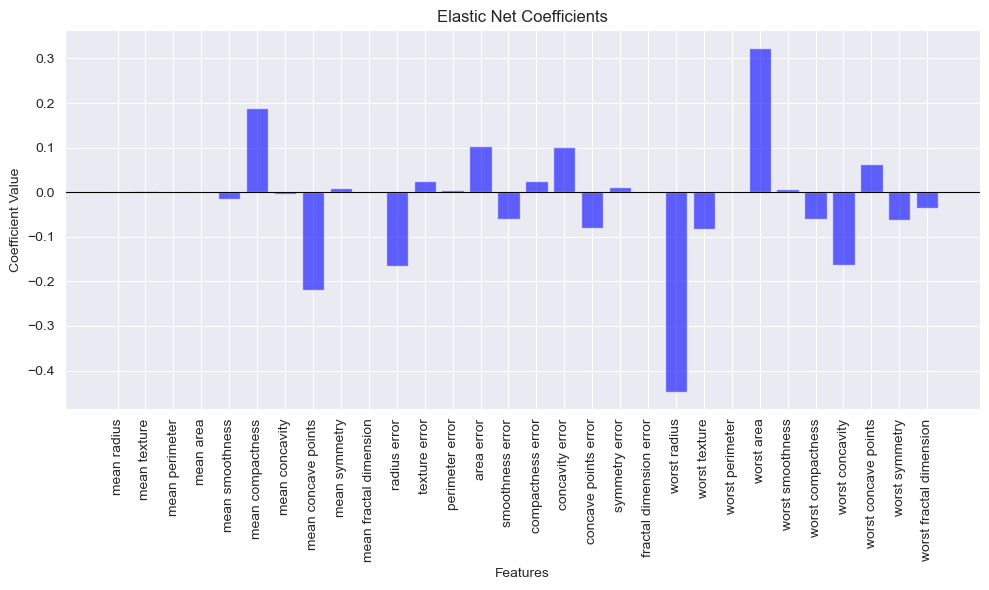

In [10]:
# Graph the coefficients
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefs)), coefs, color='blue', alpha=0.6)
plt.xticks(range(len(coefs)), X_train.columns, rotation=90)
plt.axhline(0, color='black', linewidth=0.8)
plt.title('Elastic Net Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()